In [1]:
import datetime
import random
import numpy as np
import pandas as pd
from scipy import stats
from tqdm import tqdm
from math import sqrt
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder, MEstimateEncoder, JamesSteinEncoder, LeaveOneOutEncoder, HelmertEncoder
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
import shap
import seaborn as sns
import matplotlib.pyplot as plt 
from IPython.display import display
from matplotlib.pyplot import figure

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

plt.rcParams["figure.figsize"] = (20, 15)

import warnings
warnings.filterwarnings("ignore")

In [13]:
# в одном дне дне 72 точки 
point_per_day = 72

# prev_cols_len = 360 * point_per_day
prev_cols_len = 360 
predictions_len = 7 * point_per_day

prev_cols = ["prev_" + str(i) for i in range(1, prev_cols_len + 1)][::-1]
prev_cols_days = ["prev_" + str(i) + '_day' for i in range(1, 31)][::-1]
prev_cols_hour = ["prev_" + str(i) + '_hour' for i in range(1, 24)][::-1]

key_cols = ['x', 'y', 'direction']
holidays_list = ['2023-05-01', '2023-05-08', '2023-05-09', '2023-06-12']

In [14]:
# Получение начальной (без признаков) обучающей выборки
def get_train_data(df):

    df = df.sort_values(key_cols + ['time']).reset_index(drop=True)
    
    for i in range(1, prev_cols_len + 1):
        df['prev_' + str(i)] = df.groupby(key_cols)["overload"].shift(i).rolling(30*point_per_day).sum()

    for i in range(1, 31):
        df['prev_' + str(i) + '_day'] = df.groupby(key_cols)["overload"].shift(i).rolling(point_per_day).sum()

    for i in range(1, 24):
        df['prev_' + str(i) + '_hour'] = df.groupby(key_cols)["overload"].shift(i).rolling(3).sum()

    return df

# праздников в предиктах нет
# # Получение признаков на основе дат праздников
# def get_dayoff_features(start_train, end_train):    
#     holidays_table = pd.DataFrame({'date': holidays_list})
#     holidays_table['year'] = holidays_table['date'].str[:4].astype(int)
#     holidays_table = holidays_table[['year', 'date']]
#     dates = holidays_table['date'].astype(str)    
#     data_hol = pd.DataFrame(pd.date_range(start_train, end_train), columns=['merge_date'])
#     data_hol['merge_date'] = data_hol['merge_date'].astype(str)
#     data_hol = data_hol.merge(pd.DataFrame({'merge_date': dates, 'is_holiday': 1}), how='left', on=['merge_date'])
#     data_hol['is_holiday'] = data_hol['is_holiday'].fillna(0).astype(int)
#     data_hol['weekday'] = pd.to_datetime(data_hol['merge_date']).dt.dayofweek.astype(int)
#     data_hol['is_weekend'] = data_hol['weekday'].isin({5,6}).astype(int)
#     data_hol['is_dayoff'] = (data_hol['is_holiday'] | data_hol['is_weekend']).astype(int)
#     data_hol['merge_date'] = pd.to_datetime(data_hol['merge_date'])
    
#     data_hol['key'] = 0
#     data_hol = data_hol[['merge_date', 'key']].merge(
#                 data_hol.rename({'merge_date': 'dt'}, axis=1), how='outer', on='key')
#     data_hol['merge_date_end'] = data_hol['merge_date'] + pd.DateOffset(months=1)
#     data_hol = data_hol[(data_hol.merge_date <= data_hol['dt']) &\
#                         (data_hol.merge_date_end > data_hol['dt'])].reset_index(drop=True)
#     data_hol = data_hol.groupby(['merge_date']).agg({'is_holiday': ['sum', 'mean'],
#                                                      'is_weekend': ['sum', 'mean'],
#                                                      'is_dayoff': ['sum', 'mean']})
#     data_hol.columns = ["_".join(x) for x in data_hol.columns.ravel()]
#     data_hol = data_hol.reset_index().rename({'merge_date': 'time'}, axis=1)
#     return data_hol


# Различные статистики из исторических данных
def get_stat_features(dfs):
    
    ### Statistics from previous series values
    # 1 hour
    one_hour_mask = 3
    dfs['1_hour_median'] = dfs[prev_cols[-one_hour_mask:]].median(1)
    dfs['1_hour_mean'] = dfs[prev_cols[-one_hour_mask:]].mean(1)
    dfs['1_hour_std'] = dfs[prev_cols[-one_hour_mask:]].std(1)
    dfs['1_hour_max'] = dfs[prev_cols[-one_hour_mask:]].max(1)
    dfs['1_hour_min'] = dfs[prev_cols[-one_hour_mask:]].min(1)
    dfs['1_hour_zeros_prop'] = (dfs[prev_cols[-one_hour_mask:]] == 0).mean(1)
    
    # 3 hour
    three_hour_mask = 9
    dfs['3_hour_median'] = dfs[prev_cols[-three_hour_mask:-one_hour_mask]].median(1)
    dfs['3_hour_mean'] = dfs[prev_cols[-three_hour_mask:-one_hour_mask]].mean(1)
    dfs['3_hour_std'] = dfs[prev_cols[-three_hour_mask:-one_hour_mask]].std(1)
    dfs['3_hour_max'] = dfs[prev_cols[-three_hour_mask:-one_hour_mask]].max(1)
    dfs['3_hour_min'] = dfs[prev_cols[-three_hour_mask:-one_hour_mask]].min(1)
    dfs['3_hour_zeros_prop'] = (dfs[prev_cols[-three_hour_mask:-one_hour_mask]] == 0).mean(1)

    
    # 6 hour
    six_hour_mask = 18
    dfs['6_hour_median'] = dfs[prev_cols[-six_hour_mask:-one_hour_mask]].median(1)
    dfs['6_hour_mean'] = dfs[prev_cols[-six_hour_mask:-one_hour_mask]].mean(1)
    dfs['6_hour_std'] = dfs[prev_cols[-six_hour_mask:-one_hour_mask]].std(1)
    dfs['6_hour_max'] = dfs[prev_cols[-six_hour_mask:-one_hour_mask]].max(1)
    dfs['6_hour_min'] = dfs[prev_cols[-six_hour_mask:-one_hour_mask]].min(1)
    dfs['6_hour_zeros_prop'] = (dfs[prev_cols[-six_hour_mask:-one_hour_mask]] == 0).mean(1)
    
    # 9 hour
    nine_hour_mask = 27
    dfs['9_hour_median'] = dfs[prev_cols[-nine_hour_mask:-one_hour_mask]].median(1)
    dfs['9_hour_mean'] = dfs[prev_cols[-nine_hour_mask:-one_hour_mask]].mean(1)
    dfs['9_hour_std'] = dfs[prev_cols[-nine_hour_mask:-one_hour_mask]].std(1)
    dfs['9_hour_max'] = dfs[prev_cols[-nine_hour_mask:-one_hour_mask]].max(1)
    dfs['9_hour_min'] = dfs[prev_cols[-nine_hour_mask:-one_hour_mask]].min(1)
    dfs['9_hour_zeros_prop'] = (dfs[prev_cols[-nine_hour_mask:-one_hour_mask]] == 0).mean(1)
    
    # 1_3 hour changes
    dfs['hour_three_median_change'] = (dfs['1_hour_median'] - dfs['3_hour_median']) / (dfs['3_hour_median'] + 1e-6)
    dfs['hour_three_mean_change'] = (dfs['1_hour_mean'] - dfs['3_hour_mean']) / (dfs['3_hour_mean'] + 1e-6)
    dfs['hour_three_std_change'] = (dfs['1_hour_std'] - dfs['3_hour_std']) / (dfs['3_hour_std'] + 1e-6)
    dfs['hour_three_max_change'] = (dfs['1_hour_max'] - dfs['3_hour_max']) / (dfs['3_hour_max'] + 1e-6)
    dfs['hour_three_min_change'] = (dfs['1_hour_min'] - dfs['3_hour_min']) / (dfs['3_hour_min'] + 1e-6)
    dfs['hour_three_zeros_prop_change'] = (dfs['1_hour_zeros_prop'] - dfs['3_hour_zeros_prop']) /\
                                                                        (dfs['3_hour_zeros_prop'] + 1e-6)
                                                                        
    # 1_6 hour changes
    dfs['hour_six_median_change'] = (dfs['1_hour_median'] - dfs['6_hour_median']) / (dfs['6_hour_median'] + 1e-6)
    dfs['hour_six_mean_change'] = (dfs['1_hour_mean'] - dfs['6_hour_mean']) / (dfs['6_hour_mean'] + 1e-6)
    dfs['hour_six_std_change'] = (dfs['1_hour_std'] - dfs['6_hour_std']) / (dfs['6_hour_std'] + 1e-6)
    dfs['hour_six_max_change'] = (dfs['1_hour_max'] - dfs['6_hour_max']) / (dfs['6_hour_max'] + 1e-6)
    dfs['hour_six_min_change'] = (dfs['1_hour_min'] - dfs['6_hour_min']) / (dfs['6_hour_min'] + 1e-6)
    dfs['hour_six_zeros_prop_change'] = (dfs['1_hour_zeros_prop'] - dfs['6_hour_zeros_prop']) /\
                                                                        (dfs['6_hour_zeros_prop'] + 1e-6)
                                                                        
    # 1_9 hour changes
    dfs['hour_nine_median_change'] = (dfs['1_hour_median'] - dfs['9_hour_median']) / (dfs['9_hour_median'] + 1e-6)
    dfs['hour_nine_mean_change'] = (dfs['1_hour_mean'] - dfs['6_hour_mean']) / (dfs['6_hour_mean'] + 1e-6)
    dfs['hour_nine_std_change'] = (dfs['1_hour_std'] - dfs['6_hour_std']) / (dfs['6_hour_std'] + 1e-6)
    dfs['hour_nine_max_change'] = (dfs['1_hour_max'] - dfs['6_hour_max']) / (dfs['6_hour_max'] + 1e-6)
    dfs['hour_nine_min_change'] = (dfs['1_hour_min'] - dfs['6_hour_min']) / (dfs['6_hour_min'] + 1e-6)
    dfs['hour_nine_zeros_prop_change'] = (dfs['1_hour_zeros_prop'] - dfs['6_hour_zeros_prop']) /\
                                                                        (dfs['6_hour_zeros_prop'] + 1e-6)
     # 6_9 hour changes
    dfs['six_nine_median_change'] = (dfs['6_hour_median'] - dfs['9_hour_median']) / (dfs['9_hour_median'] + 1e-6)
    dfs['six_nine_mean_change'] = (dfs['6_hour_mean'] - dfs['6_hour_mean']) / (dfs['6_hour_mean'] + 1e-6)
    dfs['six_nine_std_change'] = (dfs['6_hour_std'] - dfs['6_hour_std']) / (dfs['6_hour_std'] + 1e-6)
    dfs['six_nine_max_change'] = (dfs['6_hour_max'] - dfs['6_hour_max']) / (dfs['6_hour_max'] + 1e-6)
    dfs['six_nine_min_change'] = (dfs['6_hour_min'] - dfs['6_hour_min']) / (dfs['6_hour_min'] + 1e-6)
    dfs['six_nine_zeros_prop_change'] = (dfs['6_hour_zeros_prop'] - dfs['6_hour_zeros_prop']) /\
                                                                  (dfs['6_hour_zeros_prop'] + 1e-6)
    
    # 1 month
    month_mask = 30*point_per_day
    dfs['1_month_median'] = dfs[prev_cols[-month_mask:]].median(1)
    dfs['1_month_mean'] = dfs[prev_cols[-month_mask:]].mean(1)
    dfs['1_month_std'] = dfs[prev_cols[-month_mask:]].std(1)
    dfs['1_month_max'] = dfs[prev_cols[-month_mask:]].max(1)
    dfs['1_month_min'] = dfs[prev_cols[-month_mask:]].min(1)
    dfs['1_month_zeros_prop'] = (dfs[prev_cols[-month_mask:]] == 0).mean(1)

    # 2 month
    two_month_mask = 60*point_per_day
    dfs['2_month_median'] = dfs[prev_cols[-two_month_mask:-month_mask]].median(1)
    dfs['2_month_mean'] = dfs[prev_cols[-two_month_mask*point_per_day:-month_mask]].mean(1)
    dfs['2_month_std'] = dfs[prev_cols[-two_month_mask:-month_mask]].std(1)
    dfs['2_month_max'] = dfs[prev_cols[-two_month_mask:-month_mask]].max(1)
    dfs['2_month_min'] = dfs[prev_cols[-two_month_mask:-month_mask]].min(1)
    dfs['2_month_zeros_prop'] = (dfs[prev_cols[-two_month_mask:-month_mask]] == 0).mean(1)

    # 1_2 month changes
    dfs['month_median_change'] = (dfs['1_month_median'] - dfs['2_month_median']) / (dfs['2_month_median'] + 1e-6)
    dfs['month_mean_change'] = (dfs['1_month_mean'] - dfs['2_month_mean']) / (dfs['2_month_mean'] + 1e-6)
    dfs['month_std_change'] = (dfs['1_month_std'] - dfs['2_month_std']) / (dfs['2_month_std'] + 1e-6)
    dfs['month_max_change'] = (dfs['1_month_max'] - dfs['2_month_max']) / (dfs['2_month_max'] + 1e-6)
    dfs['month_min_change'] = (dfs['2_month_min'] - dfs['2_month_min']) / (dfs['2_month_min'] + 1e-6)
    dfs['month_zeros_prop_change'] = (dfs['1_month_zeros_prop'] - dfs['2_month_zeros_prop']) /\
                                                                        (dfs['2_month_zeros_prop'] + 1e-6)
    # 1-3 months
    three_month_mask = 90*point_per_day
    dfs['1_3_month_median'] = dfs[prev_cols[-three_month_mask:]].median(1)
    dfs['1_3_month_mean'] = dfs[prev_cols[-three_month_mask:]].mean(1)
    dfs['1_3_month_std'] = dfs[prev_cols[-three_month_mask:]].std(1)
    dfs['1_3_month_max'] = dfs[prev_cols[-three_month_mask:]].max(1)
    dfs['1_3_month_min'] = dfs[prev_cols[-three_month_mask:]].min(1)
    dfs['1_3_month_zeros_prop'] = (dfs[prev_cols[-three_month_mask:]] == 0).mean(1)
    
    # 1-3 changes to 1 month
    dfs['glob_month_median_change'] = (dfs['1_month_median'] - dfs['1_3_month_median']) /\
                                                                (dfs['1_3_month_median'] + 1e-6)
    dfs['glob_month_mean_change'] = (dfs['1_month_mean'] - dfs['1_3_month_mean']) /\
                                                                (dfs['1_3_month_mean'] + 1e-6)
    dfs['glob_month_max_change'] = (dfs['1_month_max'] - dfs['1_3_month_max']) / (dfs['1_3_month_max'] + 1e-6)
    dfs['glob_month_min_change'] = (dfs['1_month_min'] - dfs['1_3_month_min']) / (dfs['1_3_month_min'] + 1e-6)
    dfs['glob_month_zeros_prop_change'] = (dfs['1_month_zeros_prop'] - dfs['1_3_month_zeros_prop']) /\
                                                                        (dfs['1_3_month_zeros_prop'] + 1e-6)
    # такой глубины в выборке нет
    # # year
    # one_year_mask = 360*point_per_day
    # dfs['year_median'] = dfs[prev_cols[-one_year_mask:]].median(1)
    # dfs['year_mean'] = dfs[prev_cols[-one_year_mask:]].mean(1)
    # dfs['year_std'] = dfs[prev_cols[-one_year_mask:]].std(1)
    # dfs['year_max'] = dfs[prev_cols[-one_year_mask:]].max(1)
    # dfs['year_min'] = dfs[prev_cols[-one_year_mask:]].min(1)
    # dfs['year_zeros_prop'] = (dfs[prev_cols[-one_year_mask:]] == 0).mean(1)
    
    # # half year 1
    # half_year_mask_1 = 180*point_per_day
    # dfs['1_half_year_median'] = dfs[prev_cols[-half_year_mask_1:]].median(1)
    # dfs['1_half_year_mean'] = dfs[prev_cols[-half_year_mask_1:]].mean(1)
    # dfs['1_half_year_std'] = dfs[prev_cols[-half_year_mask_1:]].std(1)
    # dfs['1_half_year_max'] = dfs[prev_cols[-half_year_mask_1:]].max(1)
    # dfs['1_half_year_min'] = dfs[prev_cols[-half_year_mask_1:]].min(1)
    # dfs['1_half_year_zeros_prop'] = (dfs[prev_cols[-half_year_mask_1:]] == 0).mean(1)
    
    # # half year 2
    # dfs['2_half_year_median'] = dfs[prev_cols[-one_year_mask:-half_year_mask_1]].median(1)
    # dfs['2_half_year_mean'] = dfs[prev_cols[-one_year_mask:-half_year_mask_1]].mean(1)
    # dfs['2_half_year_std'] = dfs[prev_cols[-one_year_mask:-half_year_mask_1]].std(1)
    # dfs['2_half_year_max'] = dfs[prev_cols[-one_year_mask:-half_year_mask_1]].max(1)
    # dfs['2_half_year_min'] = dfs[prev_cols[-one_year_mask:-half_year_mask_1]].min(1)
    # dfs['2_half_year_zeros_prop'] = (dfs[prev_cols[-one_year_mask:-half_year_mask_1]] == 0).mean(1)
    
    # # half year 1 2 stats
    # dfs['half_year_median_change'] = (dfs['1_half_year_median'] - dfs['2_half_year_median']) /\
    #                                                                         (dfs['2_half_year_median'] + 1e-6)
    # dfs['half_year_week_mean_change'] = (dfs['1_half_year_mean'] - dfs['2_half_year_mean']) /\
    #                                                                         (dfs['2_half_year_mean'] + 1e-6)
    # dfs['half_year_week_std_change'] = (dfs['1_half_year_std'] - dfs['2_half_year_std']) /\
    #                                                                         (dfs['2_half_year_std'] + 1e-6)
    # dfs['half_year_week_max_change'] = (dfs['1_half_year_max'] - dfs['2_half_year_max']) /\
    #                                                                         (dfs['2_half_year_max'] + 1e-6)
    # dfs['half_year_week_min_change'] = (dfs['1_half_year_zeros_prop'] - dfs['2_half_year_min']) /\
    #                                                                         (dfs['2_half_year_min'] + 1e-6)
    # dfs['half_year_week_zeros_prop_change'] = (dfs['1_half_year_zeros_prop'] - dfs['2_half_year_zeros_prop']) /\
    #                                                                         (dfs['2_half_year_zeros_prop'] + 1e-6)
    
    # # year changes to 1 month
    # dfs['glob_year_median_change'] = (dfs['1_month_median'] - dfs['year_median']) / (dfs['year_median'] + 1e-6)
    # dfs['glob_year_mean_change'] = (dfs['1_month_mean'] - dfs['year_mean']) / (dfs['1_3_month_mean'] + 1e-6)
    # dfs['glob_year_max_change'] = (dfs['1_month_max'] - dfs['year_max']) / (dfs['year_max'] + 1e-6)
    # dfs['glob_year_min_change'] = (dfs['1_month_min'] - dfs['year_min']) / (dfs['year_min'] + 1e-6)
    # dfs['glob_year_zeros_prop_change'] = (dfs['1_month_zeros_prop'] - dfs['year_zeros_prop']) /\
    #                                                                     (dfs['year_zeros_prop'] + 1e-6) 
    # # half year changes to 1 month
    # dfs['glob_half_year_median_change'] = (dfs['1_month_median'] - dfs['1_half_year_median']) /\
    #                                                                 (dfs['1_half_year_median'] + 1e-6)
    # dfs['glob_half_year_mean_change'] = (dfs['1_month_mean'] - dfs['1_half_year_mean']) /\
    #                                                                 (dfs['1_half_year_mean'] + 1e-6)
    # dfs['glob_half_year_max_change'] = (dfs['1_month_max'] - dfs['1_half_year_max']) /\
    #                                                                 (dfs['1_half_year_max'] + 1e-6)
    # dfs['glob_half_year_min_change'] = (dfs['1_month_min'] - dfs['1_half_year_min']) /\
    #                                                                 (dfs['1_half_year_min'] + 1e-6)
    # dfs['glob_half_year_zeros_prop_change'] = (dfs['1_month_zeros_prop'] - dfs['1_half_year_zeros_prop']) /\
    #                                                                     (dfs['1_half_year_zeros_prop'] + 1e-6) 
    
    # 1 week
    one_week_mask = 7*point_per_day
    dfs['1_week_median'] = dfs[prev_cols[-one_week_mask:]].median(1)
    dfs['1_week_mean'] = dfs[prev_cols[-one_week_mask:]].mean(1)
    dfs['1_week_std'] = dfs[prev_cols[-one_week_mask:]].std(1)
    dfs['1_week_max'] = dfs[prev_cols[-one_week_mask:]].max(1)
    dfs['1_week_min'] = dfs[prev_cols[-one_week_mask:]].min(1)
    dfs['1_week_zeros_prop'] = (dfs[prev_cols[-one_week_mask:]] == 0).mean(1)

    # 2 week
    two_week_mask = 7*point_per_day
    dfs['2_week_median'] = dfs[prev_cols[-two_week_mask:-one_week_mask]].median(1)
    dfs['2_week_mean'] = dfs[prev_cols[-two_week_mask:-one_week_mask]].mean(1)
    dfs['2_week_std'] = dfs[prev_cols[-two_week_mask:-one_week_mask]].std(1)
    dfs['2_week_max'] = dfs[prev_cols[-two_week_mask:-one_week_mask]].max(1)
    dfs['2_week_min'] = dfs[prev_cols[-two_week_mask:-one_week_mask]].min(1)
    dfs['2_week_zeros_prop'] = (dfs[prev_cols[-two_week_mask:-one_week_mask]] == 0).mean(1)
    
    # 1_2 week changes
    dfs['week_median_change'] = (dfs['1_week_median'] - dfs['2_week_median']) / (dfs['2_week_median'] + 1e-6)
    dfs['week_mean_change'] = (dfs['1_week_mean'] - dfs['2_week_mean']) / (dfs['2_week_mean'] + 1e-6)
    dfs['week_std_change'] = (dfs['1_week_std'] - dfs['2_week_std']) / (dfs['2_week_std'] + 1e-6)
    dfs['week_max_change'] = (dfs['1_week_max'] - dfs['2_week_max']) / (dfs['2_week_max'] + 1e-6)
    dfs['week_min_change'] = (dfs['2_week_min'] - dfs['2_week_min']) / (dfs['2_week_min'] + 1e-6)
    dfs['week_zeros_prop_change'] = (dfs['1_week_zeros_prop'] - dfs['2_week_zeros_prop']) /\
                                                                        (dfs['2_week_zeros_prop'] + 1e-6)
    # 1 day statistics
    dfs['1_2_day_perc'] = (dfs['prev_1'] - dfs['prev_2']) / (dfs['prev_2'] + 1e-6)
    dfs['1_2_day_diff'] = dfs['prev_1'] - dfs['prev_2']
    dfs['1_day_month_change_mean'] = (dfs['prev_1'] - dfs['1_month_mean']) / (dfs['1_month_mean'] + 1e-6)
    dfs['1_day_month_change_median'] = (dfs['prev_1'] - dfs['1_month_median']) / (dfs['1_month_median'] + 1e-6)
    dfs['1_day_month_change_max'] = (dfs['prev_1'] - dfs['1_month_max']) / (dfs['1_month_max'] + 1e-6)
    dfs['1_day_month_change_min'] = (dfs['prev_1'] - dfs['1_month_min']) / (dfs['1_month_min'] + 1e-6)
    dfs['1_day_week_change_mean'] = (dfs['prev_1'] - dfs['1_week_mean']) / (dfs['1_week_mean'] + 1e-6)
    dfs['1_day_week_change_median'] = (dfs['prev_1'] - dfs['1_week_median']) / (dfs['1_week_median'] + 1e-6)
    dfs['1_day_week_change_max'] = (dfs['prev_1'] - dfs['1_week_max']) / (dfs['1_week_max'] + 1e-6)
    dfs['1_day_week_change_min'] = (dfs['prev_1'] - dfs['1_week_min']) / (dfs['1_week_min'] + 1e-6)  
    
    return dfs


# Признак: сколько дней были одинаковые значения
def add_lr_features(df):    
    buffs = pd.DataFrame((df[prev_cols[1:]].values != df[prev_cols[:-1]].values) |\
                         (df[prev_cols[1:]].values == 0)).multiply(range(prev_cols_len - 1, 0, -1), axis=1)
    buffs = (buffs != 0).multiply(range(prev_cols_len - 1), axis=1)
    df['equal_days_befor_target'] = prev_cols_len - 1 - buffs.idxmax(1)    
    return df

# Признаки на основе длин массивов нулей за историю
def get_zeros_mass_features(df):
    def get_zeros_length(x):
        return np.arange(len(x))[(x == 0) & (np.concatenate([x[1:], np.array([-1])]) != 0)] -\
               np.arange(len(x))[(x == 0) & (np.concatenate([np.array([-1]), x[:-1]]) != 0)] + 1
    df['zeros_masses'] = df[prev_cols].apply(lambda x: get_zeros_length(x.values), axis=1)
    df['last_zeros_len'] = df['zeros_masses'].apply(lambda x: x[-1] if len(x) > 0 else -1)
    df['zeros_mass_mean'] = df['zeros_masses'].apply(lambda x: np.mean(x) if len(x) > 0 else -1)
    df['zeros_mass_median'] = df['zeros_masses'].apply(lambda x: np.median(x) if len(x) > 0 else -1)
    df['zeros_mass_std'] = df['zeros_masses'].apply(lambda x: np.std(x) if len(x) > 0 else -1)
    df['zeros_mass_cnt'] = df['zeros_masses'].apply(lambda x: len(x))
    df['zeros_mass_max'] = df['zeros_masses'].apply(lambda x: np.max(x) if len(x) > 0 else -1)
    df.drop(['zeros_masses'], axis=1, inplace=True)
    return df


# Признаки на основе истории по дням за последний месяц
def get_last_days_features(df):
    df['last_day_total'] = df['prev_1_day'] * 30
    df['last_week_total'] = df[prev_cols_days[-7:]].sum(1) / 7 * 30
    df['last_2_week_total'] = df[prev_cols_days[-14:-7]].sum(1) / 7 * 30
    df['last_one_hour'] = df[prev_cols_hour[-3:]].sum(1) / 3 * 24 
    df['last_three_hour'] = df[prev_cols_hour[-9:]].sum(1) / 9 * 24 
    df['last_six_hour'] = df[prev_cols_hour[-18:]].sum(1) / 18 * 24 
    df['last_9_hour'] = df[prev_cols_hour[-27:]].sum(1) / 27 * 24 
    df['last_12_hour'] = df[prev_cols_hour[-36:]].sum(1) / 36 * 24 
    df['last_16_hour'] = df[prev_cols_hour[-48:]].sum(1) / 48 * 24 
    df['last_month_total'] = df['prev_1'].copy()
    
    df['perc_last_day_week_total'] = df['last_day_total'] / (df['last_week_total'] + 1e-6)
    df['perc_last_day_month_total'] = df['last_day_total'] / (df['last_month_total'] + 1e-6)
    df['perc_last_week_month_total'] = df['last_week_total'] / (df['last_month_total'] + 1e-6)
    df['perc_last_double_weeks_month_total'] = (df['last_week_total'] + df['last_week_total']) /\
                                                                        (2 * df['last_month_total'] + 1e-6)
    df['perc_last_week_2_week_total'] = df['last_week_total'] / (df['last_2_week_total'] + 1e-6)
    df['perc_last_week_double_week_total'] = df['last_week_total'] * 2 /\
                                                (df['last_2_week_total'] + df['last_week_total'] + 1e-6)
    return df


def preprocessing(df):
    df = get_train_data(df)
    df = get_stat_features(df)
    df = add_lr_features(df)
    print('add_lr_features finished')
    df = get_zeros_mass_features(df)
    print('get_zeros_mass_features finished')
    df = get_last_days_features(df)
    print('get_last_days_features finished')
    df['hour'] = df['time'].dt.hour
    df['weekday'] = df['time'].dt.dayofweek
    df['week_number'] = df['time'].dt.isocalendar().week

    le = LabelEncoder()
    df['direction'] = le.fit_transform(df['direction'])
    
    return df

В городе на каждой дороге поставили камеры для измерения ее загруженности каждые 20 минут. Собирается статистика в формате: 
    
    x - координата средней точки проезжей части с востока на запад, 
    y - координата средней точки дороги с севера на юг, 
    direction - направление движения проезжей части, 
    time - время измерения, 
    overload - загруженность дороги (от 0 до 100). 

Необходимо спрогнозировать загруженность всех дорог (сочетание x, y, direction) на следующую неделю с интервалом 20 минут.

In [5]:
df = pd.read_excel('train_dataset.xlsx')

print(df.sample(1))

       x  y                time direction  overload
60112  2  2 2023-04-13 20:00:00        NB        60


In [6]:
start_train = min(df['time']).strftime('%Y-%m-%d')
end_train = max(df['time']).strftime('%Y-%m-%d')

start_train, end_train

('2023-04-01', '2023-09-30')

In [15]:
# заполняем пропущенные даты нулями
unique_rows = df[key_cols].drop_duplicates()
unique_rows['key'] = 0

dates_data = pd.DataFrame({'time': pd.date_range(start=start_train, end=end_train, freq="20min")})
dates_data['key'] = 0
all_rows_date = unique_rows.merge(dates_data, how='outer', on=['key']).drop(['key'], axis=1)
df = all_rows_date.merge(df, how='left', on=key_cols + ['time'])

dt = datetime.datetime(2023,5,15)
df[df['time'] == dt].head(3)

,x,y,direction,time,overload
3168,0,0,EB,2023-05-15,NaN
16273,0,0,NB,2023-05-15,NaN
29378,0,0,SB,2023-05-15,NaN


In [16]:
df['overload'] = df['overload'].fillna(0).astype(int)

#### split выборки

In [17]:
# после datetime.datetime(2023,6,1) остаётся 66% выборки
# после datetime.datetime(2023,7,1) 49% выборки
# после datetime.datetime(2023,8,1) 32% выборки
# после datetime.datetime(2023,8,30) 17% выборки

In [18]:
# берём меньший размер выборки, чтобы быстрее считалось
mini_df = df[df['time'] > datetime.datetime(2023,7,1)]
len(mini_df)/len(df)

0.4999618466234262

In [19]:
mini_df = mini_df.sort_values('time').reset_index()

test_size = 0.2
test_index = int(len(mini_df)*(1-test_size))


X_train = mini_df.loc[:test_index]
y_train = mini_df.loc[:test_index]["overload"]

y_test = mini_df.loc[test_index:]["overload"]
X_test = mini_df.loc[test_index:]
X_test["overload"] = 0

len(X_train)/len(mini_df)*100, len(X_test)/len(mini_df)*100

(80.00023480792711, 20.0)

In [20]:
# не подглядываем в будущее
print(min(X_train['time']),  max(X_train['time']))
print(min(X_test['time']),  max(X_test['time']))

2023-07-01 00:20:00 2023-09-11 19:20:00
2023-09-11 19:20:00 2023-09-30 00:00:00


In [21]:
traintest = pd.concat([X_train, X_test], axis=0)
traintest.shape[0] == X_train.shape[0] + X_test.shape[0] 

True

In [22]:
%%time
traintest_processed = preprocessing(traintest)
traintest_processed.head(2)

add_lr_features finished
get_zeros_mass_features finished
get_last_days_features finished
CPU times: user 50.2 s, sys: 11.3 s, total: 1min 1s
Wall time: 1min 2s


,index,x,y,direction,time,overload,prev_1,prev_2,prev_3,prev_4,prev_5,prev_6,prev_7,prev_8,prev_9,prev_10,prev_11,prev_12,prev_13,prev_14,prev_15,prev_16,prev_17,prev_18,prev_19,prev_20,prev_21,prev_22,prev_23,prev_24,prev_25,prev_26,prev_27,prev_28,prev_29,prev_30,prev_31,prev_32,prev_33,prev_34,prev_35,prev_36,prev_37,prev_38,prev_39,prev_40,prev_41,prev_42,prev_43,prev_44,prev_45,prev_46,prev_47,prev_48,prev_49,prev_50,prev_51,prev_52,prev_53,prev_54,prev_55,prev_56,prev_57,prev_58,prev_59,prev_60,prev_61,prev_62,prev_63,prev_64,prev_65,prev_66,prev_67,prev_68,prev_69,prev_70,prev_71,prev_72,prev_73,prev_74,prev_75,prev_76,prev_77,prev_78,prev_79,prev_80,prev_81,prev_82,prev_83,prev_84,prev_85,prev_86,prev_87,prev_88,prev_89,prev_90,prev_91,prev_92,prev_93,prev_94,prev_95,prev_96,prev_97,prev_98,prev_99,prev_100,prev_101,prev_102,prev_103,prev_104,prev_105,prev_106,prev_107,prev_108,prev_109,prev_110,prev_111,prev_112,prev_113,prev_114,prev_115,prev_116,prev_117,prev_118,prev_119,prev_120,prev_121,prev_122,prev_123,prev_124,prev_125,prev_126,prev_127,prev_128,prev_129,prev_130,prev_131,prev_132,prev_133,prev_134,prev_135,prev_136,prev_137,prev_138,prev_139,prev_140,prev_141,prev_142,prev_143,prev_144,prev_145,prev_146,prev_147,prev_148,prev_149,prev_150,prev_151,prev_152,prev_153,prev_154,prev_155,prev_156,prev_157,prev_158,prev_159,prev_160,prev_161,prev_162,prev_163,prev_164,prev_165,prev_166,prev_167,prev_168,prev_169,prev_170,prev_171,prev_172,prev_173,prev_174,prev_175,prev_176,prev_177,prev_178,prev_179,prev_180,prev_181,prev_182,prev_183,prev_184,prev_185,prev_186,prev_187,prev_188,prev_189,prev_190,prev_191,prev_192,prev_193,prev_194,prev_195,prev_196,prev_197,prev_198,prev_199,prev_200,prev_201,prev_202,prev_203,prev_204,prev_205,prev_206,prev_207,prev_208,prev_209,prev_210,prev_211,prev_212,prev_213,prev_214,prev_215,prev_216,prev_217,prev_218,prev_219,prev_220,prev_221,prev_222,prev_223,prev_224,prev_225,prev_226,prev_227,prev_228,prev_229,prev_230,prev_231,prev_232,prev_233,prev_234,prev_235,prev_236,prev_237,prev_238,prev_239,prev_240,prev_241,prev_242,prev_243,prev_244,prev_245,prev_246,prev_247,prev_248,prev_249,prev_250,prev_251,prev_252,prev_253,prev_254,prev_255,prev_256,prev_257,prev_258,prev_259,prev_260,prev_261,prev_262,prev_263,prev_264,prev_265,prev_266,prev_267,prev_268,prev_269,prev_270,prev_271,prev_272,prev_273,prev_274,prev_275,prev_276,prev_277,prev_278,prev_279,prev_280,prev_281,prev_282,prev_283,prev_284,prev_285,prev_286,prev_287,prev_288,prev_289,prev_290,prev_291,prev_292,prev_293,prev_294,prev_295,prev_296,prev_297,prev_298,prev_299,prev_300,prev_301,prev_302,prev_303,prev_304,prev_305,prev_306,prev_307,prev_308,prev_309,prev_310,prev_311,prev_312,prev_313,prev_314,prev_315,prev_316,prev_317,prev_318,prev_319,prev_320,prev_321,prev_322,prev_323,prev_324,prev_325,prev_326,prev_327,prev_328,prev_329,prev_330,prev_331,prev_332,prev_333,prev_334,prev_335,prev_336,prev_337,prev_338,prev_339,prev_340,prev_341,prev_342,prev_343,prev_344,prev_345,prev_346,prev_347,prev_348,prev_349,prev_350,prev_351,prev_352,prev_353,prev_354,prev_355,prev_356,prev_357,prev_358,prev_359,prev_360,prev_1_day,prev_2_day,prev_3_day,prev_4_day,prev_5_day,prev_6_day,prev_7_day,prev_8_day,prev_9_day,prev_10_day,prev_11_day,prev_12_day,prev_13_day,prev_14_day,prev_15_day,prev_16_day,prev_17_day,prev_18_day,prev_19_day,prev_20_day,prev_21_day,prev_22_day,prev_23_day,prev_24_day,prev_25_day,prev_26_day,prev_27_day,prev_28_day,prev_29_day,prev_30_day,prev_1_hour,prev_2_hour,prev_3_hour,prev_4_hour,prev_5_hour,prev_6_hour,prev_7_hour,prev_8_hour,prev_9_hour,prev_10_hour,prev_11_hour,prev_12_hour,prev_13_hour,prev_14_hour,prev_15_hour,prev_16_hour,prev_17_hour,prev_18_hour,prev_19_hour,prev_20_hour,prev_21_hour,prev_22_hour,prev_23_hour,1_hour_median,1_hour_mean,1_hour_std,1_hour_max,1_hour_min,1_hour_zeros_prop,3_hour_median,3_hour_mean,3_hour_std,3_hour_max,3_hour_min,3_hour_zeros_prop,6_hour_median,6_hour_mean,6_hour_std,6

In [20]:
# traintest_processed.to_csv('traintest_processed.csv')

In [23]:
# X_train_processed.to_csv('X_train_processed.csv')
traintest_processed.shape[0] == y_train.shape[0] + y_test.shape[0]

True

In [24]:
traintest_processed.isnull().sum().sum()

69047042

### отбор признаков

In [25]:
X_train_processed = traintest_processed[:test_index].drop('overload', axis=1)
X_test_processed = traintest_processed[test_index:].drop('overload', axis=1)

len(X_train_processed)/len(traintest_processed), len(X_test_processed)/len(traintest_processed)

(0.7999981215409938, 0.20000187845900616)

In [26]:
X_train_processed.shape[0], y_train.shape, X_test_processed.shape[0], y_test.shape,

(340704, (340705,), 85177, (85176,))

In [27]:
# TODO: костыль
y_train = y_train[:-1]
X_test_processed = X_test_processed[:-1]

#### feature_importance

In [28]:
val_size = 0.25
val_index = int(len(X_train_processed)*(1-val_size))
X_train_processed = X_train_processed.sort_values('time')

X_train_cb, y_train_cb = X_train_processed[:val_index], y_train[:val_index]
X_val_cb, y_val_cb = X_train_processed[val_index:], y_train[val_index:]

In [30]:
print(min(X_train_cb['time']),  max(X_train_cb['time']))
print(min(X_val_cb['time']),  max(X_val_cb['time']))

2023-07-01 00:20:00 2023-09-07 06:00:00
2023-09-07 06:20:00 2023-09-30 00:00:00


In [31]:
cat_features = ['direction']

In [32]:
pool_train = Pool(X_train_cb, y_train_cb, cat_features=cat_features) 
pool_val = Pool(X_val_cb, y_val_cb, cat_features=cat_features)

In [33]:
%%time
model = CatBoostRegressor(random_state=42,
                           # cat_features=cat_cols,
                           thread_count=-1)
model.fit(pool_train, 
          eval_set=pool_val,
          verbose=100, plot=False, 
          early_stopping_rounds=100)

Learning rate set to 0.12158
0:	learn: 17.1160644	test: 17.3510903	best: 17.3510903 (0)	total: 204ms	remaining: 3m 23s
100:	learn: 16.7798523	test: 18.2900350	best: 17.3510903 (0)	total: 20.3s	remaining: 3m
Stopped by overfitting detector  (100 iterations wait)

bestTest = 17.35109033
bestIteration = 0

Shrink model to first 1 iterations.
CPU times: user 2min 29s, sys: 2.11 s, total: 2min 31s
Wall time: 22 s


In [34]:
model.save_model('catboost_get_feature_importance')

In [35]:
fi = model.get_feature_importance(prettified=True)
fi[:10]

,Feature Id,Importances
0,time,63.862192
1,weekday,25.389265
2,prev_20_hour,10.748544
3,index,0.000000
4,x,0.000000
5,y,0.000000
6,direction,0.000000
7,prev_1,0.000000
8,prev_2,0.000000
9,prev_3,0.000000


In [36]:
fi.to_csv('feature_importance.csv')

In [37]:
X_train_processed[fi['Feature Id'][:15].to_list()].sample()

,time,weekday,prev_20_hour,index,x,y,direction,prev_1,prev_2,prev_3,prev_4,prev_5,prev_6,prev_7,prev_8
127341,2023-08-09 15:20:00,2,192.0,258401,1,0,2,123993.0,124019.0,124059.0,124063.0,124063.0,124063.0,124089.0,124080.0


In [38]:
# feature_importance = model.feature_importances_
# sorted_idx = np.argsort(feature_importance)
# fig = plt.figure(figsize=(12, 6))
# plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
# plt.yticks(range(len(sorted_idx)), np.array(X_train_processed.columns)[sorted_idx])
# plt.title('Feature Importance');

#### shap

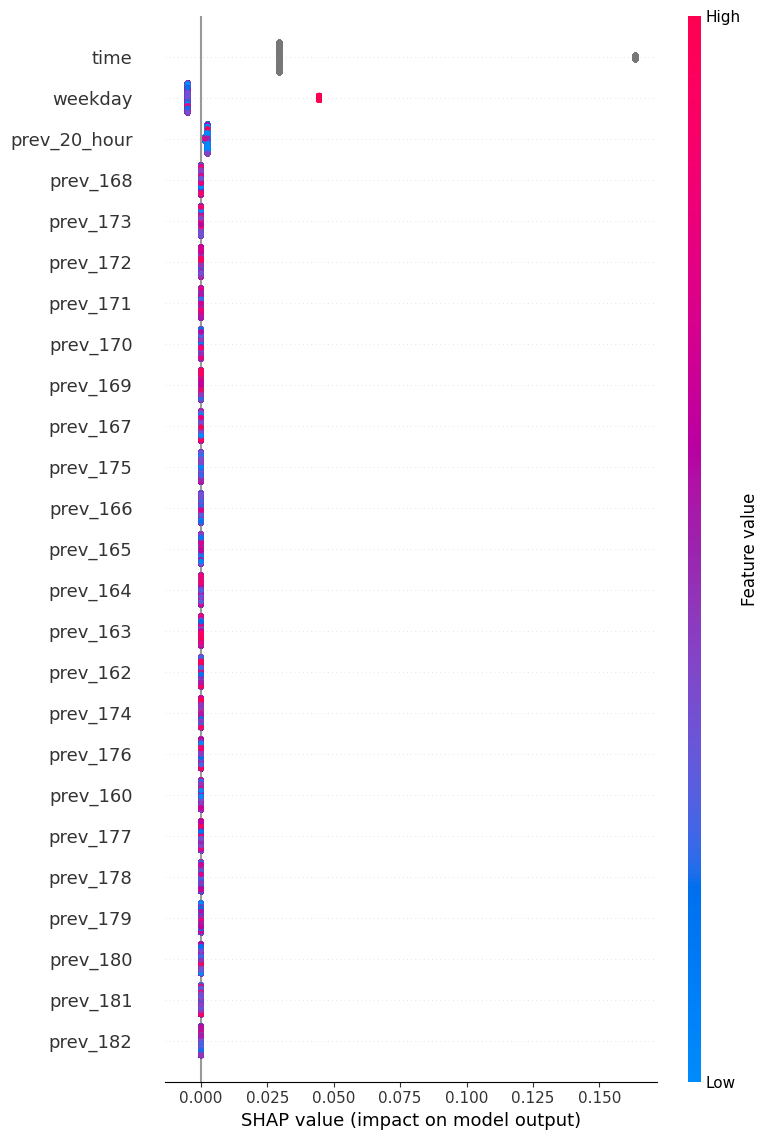

CPU times: user 35.4 s, sys: 1.86 s, total: 37.3 s
Wall time: 23.7 s


In [39]:
%%time
explainer = shap.TreeExplainer(model)

# TODO: на тесте?
val_dataset = pool_val
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_val_cb, max_display = 25)

In [40]:
feature_names =  X_train_processed.columns
rf_result = pd.DataFrame(shap_values, columns = feature_names)
vals = np.abs(rf_result.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
shap_importance[:10]

,col_name,feature_importance_vals
4,time,0.047141
524,weekday,0.010275
414,prev_20_hour,0.002309
0,index,0.000000
354,prev_350,0.000000
349,prev_345,0.000000
350,prev_346,0.000000
351,prev_347,0.000000
352,prev_348,0.000000
353,prev_349,0.000000


In [42]:
shap_importance[shap_importance['col_name'].isin(['x','y','direction'])]

,col_name,feature_importance_vals
1,x,0.0
3,direction,0.0
2,y,0.0


In [91]:
shap_cols = shap_importance['col_name'][:100].values
shap_cols = list(shap_cols)
shap_cols.remove('index')

In [46]:
shap_importance.to_csv('shap_importance.csv')

#### permutation_importance

In [75]:
# %%time
# perm_importance = permutation_importance(model, X_val_processed, y_val, n_repeats=10, random_state=1066)
# sorted_idx = perm_importance.importances_mean.argsort()
# fig = plt.figure(figsize=(12, 6))
# plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
# plt.yticks(range(len(sorted_idx)), np.array(X_val_processed.columns)[sorted_idx])
# plt.title('Permutation Importance');

In [76]:
# permut_importance = pd.DataFrame(list(zip(X_val_processed.columns, perm_importance.importances_mean[sorted_idx])),
#                                   columns=['col_name','perm_importance_vals'])
# shap_importance.sort_values(by=['perm_importance_vals'],
# permut_importanceascending=False, inplace=True)

In [77]:
# permut_importance.to_csv('permut_importance.csv')

#### модель

In [ ]:
# метрика для обучения
# значение не должно быть > 100 и <0
# rms = sqrt(mean_squared_error(y_actual, y_predicted))

In [44]:
%%time
model = CatBoostRegressor(
    random_seed=42,
    thread_count=-1,
    # cat_features=cat_features,
    eval_metric="RMSE",
    verbose=500,
)

param_distribution = {
    "one_hot_max_size": stats.bernoulli(p=0.2, loc=2),
    "learning_rate": [0.03, 0.1, 0.3],
    "l2_leaf_reg": [2, 5, 7],
    "depth": stats.binom(n=10, p=0.2),
}
randomized_search_result = model.randomized_search(param_distribution, X_train_processed[shap_cols], y_train)
model.best_score_

0:	learn: 49.2966783	test: 49.2868474	best: 49.2868474 (0)	total: 6.86ms	remaining: 6.85s
500:	learn: 17.1764792	test: 17.1991078	best: 17.1990975 (256)	total: 2.22s	remaining: 2.21s
999:	learn: 17.1764792	test: 17.1991079	best: 17.1990975 (256)	total: 4.25s	remaining: 0us

bestTest = 17.19909746
bestIteration = 256

0:	loss: 17.1990975	best: 17.1990975 (0)	total: 4.62s	remaining: 41.6s
0:	learn: 49.2967364	test: 49.2868635	best: 49.2868635 (0)	total: 37.5ms	remaining: 37.5s
500:	learn: 16.9339918	test: 16.9691144	best: 16.9691144 (500)	total: 17.5s	remaining: 17.4s
999:	learn: 16.7852533	test: 16.8347265	best: 16.8347265 (999)	total: 34.5s	remaining: 0us

bestTest = 16.83472652
bestIteration = 999

1:	loss: 16.8347265	best: 16.8347265 (1)	total: 39.2s	remaining: 2m 36s
0:	learn: 49.2966895	test: 49.2868463	best: 49.2868463 (0)	total: 17.2ms	remaining: 17.2s
500:	learn: 17.0734629	test: 17.0988561	best: 17.0988561 (500)	total: 10.2s	remaining: 10.1s
999:	learn: 16.9823748	test: 17.0101

{'learn': {'RMSE': 16.498535633637058}}

In [46]:
randomized_search_result["params"]

{'l2_leaf_reg': 5, 'depth': 3.0, 'one_hot_max_size': 3.0, 'learning_rate': 0.3}

In [50]:
model.best_score_

{'learn': {'RMSE': 16.169168485686953}}

In [94]:
pool_train = Pool(X_train_cb[shap_cols], y_train_cb) 
pool_val = Pool(X_val_cb[shap_cols], y_val_cb)

In [95]:
opt_model = CatBoostRegressor(
    random_seed=42,
    thread_count=-1,
    l2_leaf_reg=5,
     depth=3.0, 
    one_hot_max_size=3.0, 
    learning_rate=0.3,
    # cat_features=cat_features,
    eval_metric="RMSE",
    verbose=500,
)

opt_model.fit(pool_train, 
          eval_set=pool_val,
          verbose=100, plot=False, 
          early_stopping_rounds=100)

0:	learn: 17.1188113	test: 17.3411138	best: 17.3411138 (0)	total: 20.2ms	remaining: 20.2s
100:	learn: 16.7774764	test: 17.4970593	best: 17.3411138 (0)	total: 2.1s	remaining: 18.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 17.34111383
bestIteration = 0

Shrink model to first 1 iterations.


In [96]:
y_pred = opt_model.predict(X_test_processed[shap_cols])
y_pred.shape, y_test.shape

((85176,), (85176,))

In [97]:
sqrt(mean_squared_error(y_pred, y_test))

18.27548342878534

In [98]:
# сравним с безлайном - предсказанием среднего за предыдущие 3 недели

In [99]:
N = len(X_test)
last_data = X_train.sort_values('time')[:N]
N

85176

In [100]:
X_test = X_test.sort_values('time')
X_test['overload_baseline'] = last_data['overload'].values
X_test.head()

,index,x,y,direction,time,overload,overload_baseline
340704,850514,2,3,WB,2023-09-11 19:20:00,0,38
340719,798094,2,3,NB,2023-09-11 19:20:00,0,49
340720,208369,0,3,SW,2023-09-11 19:20:00,0,16
340721,693254,2,2,NB,2023-09-11 19:20:00,0,44
340722,588414,2,1,NB,2023-09-11 19:20:00,0,46


In [101]:
sqrt(mean_squared_error(X_test.overload_baseline, y_test))

24.847164790026888

### предикт неизвестных таргетов 

In [102]:
df = pd.read_excel('train_dataset.xlsx')

end_train =  datetime.datetime(2023,9,30)
future_date = end_train + datetime.timedelta(days=7)
future_date

datetime.datetime(2023, 10, 7, 0, 0)

In [103]:
unique_rows = df[key_cols].drop_duplicates()
unique_rows['key'] = 0

dates_data = pd.DataFrame({'time': pd.date_range(start=end_train, end=future_date, freq="20min")})
dates_data['key'] = 0
all_rows_date = unique_rows.merge(dates_data, how='outer', on=['key']).drop(['key'], axis=1)

In [104]:
df = all_rows_date.merge(df, how='left', on=key_cols + ['time'])
df[df['time'] == datetime.datetime(2023, 10, 5)].sample()

,x,y,direction,time,overload
27630,2,2,NW,2023-10-05,NaN


In [105]:
%%time
traintest_processed = preprocessing(df)
traintest_processed.head(2)

add_lr_features finished
get_zeros_mass_features finished
get_last_days_features finished
CPU times: user 3.92 s, sys: 431 ms, total: 4.36 s
Wall time: 4.4 s


,x,y,direction,time,overload,prev_1,prev_2,prev_3,prev_4,prev_5,prev_6,prev_7,prev_8,prev_9,prev_10,prev_11,prev_12,prev_13,prev_14,prev_15,prev_16,prev_17,prev_18,prev_19,prev_20,prev_21,prev_22,prev_23,prev_24,prev_25,prev_26,prev_27,prev_28,prev_29,prev_30,prev_31,prev_32,prev_33,prev_34,prev_35,prev_36,prev_37,prev_38,prev_39,prev_40,prev_41,prev_42,prev_43,prev_44,prev_45,prev_46,prev_47,prev_48,prev_49,prev_50,prev_51,prev_52,prev_53,prev_54,prev_55,prev_56,prev_57,prev_58,prev_59,prev_60,prev_61,prev_62,prev_63,prev_64,prev_65,prev_66,prev_67,prev_68,prev_69,prev_70,prev_71,prev_72,prev_73,prev_74,prev_75,prev_76,prev_77,prev_78,prev_79,prev_80,prev_81,prev_82,prev_83,prev_84,prev_85,prev_86,prev_87,prev_88,prev_89,prev_90,prev_91,prev_92,prev_93,prev_94,prev_95,prev_96,prev_97,prev_98,prev_99,prev_100,prev_101,prev_102,prev_103,prev_104,prev_105,prev_106,prev_107,prev_108,prev_109,prev_110,prev_111,prev_112,prev_113,prev_114,prev_115,prev_116,prev_117,prev_118,prev_119,prev_120,prev_121,prev_122,prev_123,prev_124,prev_125,prev_126,prev_127,prev_128,prev_129,prev_130,prev_131,prev_132,prev_133,prev_134,prev_135,prev_136,prev_137,prev_138,prev_139,prev_140,prev_141,prev_142,prev_143,prev_144,prev_145,prev_146,prev_147,prev_148,prev_149,prev_150,prev_151,prev_152,prev_153,prev_154,prev_155,prev_156,prev_157,prev_158,prev_159,prev_160,prev_161,prev_162,prev_163,prev_164,prev_165,prev_166,prev_167,prev_168,prev_169,prev_170,prev_171,prev_172,prev_173,prev_174,prev_175,prev_176,prev_177,prev_178,prev_179,prev_180,prev_181,prev_182,prev_183,prev_184,prev_185,prev_186,prev_187,prev_188,prev_189,prev_190,prev_191,prev_192,prev_193,prev_194,prev_195,prev_196,prev_197,prev_198,prev_199,prev_200,prev_201,prev_202,prev_203,prev_204,prev_205,prev_206,prev_207,prev_208,prev_209,prev_210,prev_211,prev_212,prev_213,prev_214,prev_215,prev_216,prev_217,prev_218,prev_219,prev_220,prev_221,prev_222,prev_223,prev_224,prev_225,prev_226,prev_227,prev_228,prev_229,prev_230,prev_231,prev_232,prev_233,prev_234,prev_235,prev_236,prev_237,prev_238,prev_239,prev_240,prev_241,prev_242,prev_243,prev_244,prev_245,prev_246,prev_247,prev_248,prev_249,prev_250,prev_251,prev_252,prev_253,prev_254,prev_255,prev_256,prev_257,prev_258,prev_259,prev_260,prev_261,prev_262,prev_263,prev_264,prev_265,prev_266,prev_267,prev_268,prev_269,prev_270,prev_271,prev_272,prev_273,prev_274,prev_275,prev_276,prev_277,prev_278,prev_279,prev_280,prev_281,prev_282,prev_283,prev_284,prev_285,prev_286,prev_287,prev_288,prev_289,prev_290,prev_291,prev_292,prev_293,prev_294,prev_295,prev_296,prev_297,prev_298,prev_299,prev_300,prev_301,prev_302,prev_303,prev_304,prev_305,prev_306,prev_307,prev_308,prev_309,prev_310,prev_311,prev_312,prev_313,prev_314,prev_315,prev_316,prev_317,prev_318,prev_319,prev_320,prev_321,prev_322,prev_323,prev_324,prev_325,prev_326,prev_327,prev_328,prev_329,prev_330,prev_331,prev_332,prev_333,prev_334,prev_335,prev_336,prev_337,prev_338,prev_339,prev_340,prev_341,prev_342,prev_343,prev_344,prev_345,prev_346,prev_347,prev_348,prev_349,prev_350,prev_351,prev_352,prev_353,prev_354,prev_355,prev_356,prev_357,prev_358,prev_359,prev_360,prev_1_day,prev_2_day,prev_3_day,prev_4_day,prev_5_day,prev_6_day,prev_7_day,prev_8_day,prev_9_day,prev_10_day,prev_11_day,prev_12_day,prev_13_day,prev_14_day,prev_15_day,prev_16_day,prev_17_day,prev_18_day,prev_19_day,prev_20_day,prev_21_day,prev_22_day,prev_23_day,prev_24_day,prev_25_day,prev_26_day,prev_27_day,prev_28_day,prev_29_day,prev_30_day,prev_1_hour,prev_2_hour,prev_3_hour,prev_4_hour,prev_5_hour,prev_6_hour,prev_7_hour,prev_8_hour,prev_9_hour,prev_10_hour,prev_11_hour,prev_12_hour,prev_13_hour,prev_14_hour,prev_15_hour,prev_16_hour,prev_17_hour,prev_18_hour,prev_19_hour,prev_20_hour,prev_21_hour,prev_22_hour,prev_23_hour,1_hour_median,1_hour_mean,1_hour_std,1_hour_max,1_hour_min,1_hour_zeros_prop,3_hour_median,3_hour_mean,3_hour_std,3_hour_max,3_hour_min,3_hour_zeros_prop,6_hour_median,6_hour_mean,6_hour_std,6_hour_

In [106]:
res = traintest_processed[traintest_processed['time'] > end_train]
res.head(2)

,x,y,direction,time,overload,prev_1,prev_2,prev_3,prev_4,prev_5,prev_6,prev_7,prev_8,prev_9,prev_10,prev_11,prev_12,prev_13,prev_14,prev_15,prev_16,prev_17,prev_18,prev_19,prev_20,prev_21,prev_22,prev_23,prev_24,prev_25,prev_26,prev_27,prev_28,prev_29,prev_30,prev_31,prev_32,prev_33,prev_34,prev_35,prev_36,prev_37,prev_38,prev_39,prev_40,prev_41,prev_42,prev_43,prev_44,prev_45,prev_46,prev_47,prev_48,prev_49,prev_50,prev_51,prev_52,prev_53,prev_54,prev_55,prev_56,prev_57,prev_58,prev_59,prev_60,prev_61,prev_62,prev_63,prev_64,prev_65,prev_66,prev_67,prev_68,prev_69,prev_70,prev_71,prev_72,prev_73,prev_74,prev_75,prev_76,prev_77,prev_78,prev_79,prev_80,prev_81,prev_82,prev_83,prev_84,prev_85,prev_86,prev_87,prev_88,prev_89,prev_90,prev_91,prev_92,prev_93,prev_94,prev_95,prev_96,prev_97,prev_98,prev_99,prev_100,prev_101,prev_102,prev_103,prev_104,prev_105,prev_106,prev_107,prev_108,prev_109,prev_110,prev_111,prev_112,prev_113,prev_114,prev_115,prev_116,prev_117,prev_118,prev_119,prev_120,prev_121,prev_122,prev_123,prev_124,prev_125,prev_126,prev_127,prev_128,prev_129,prev_130,prev_131,prev_132,prev_133,prev_134,prev_135,prev_136,prev_137,prev_138,prev_139,prev_140,prev_141,prev_142,prev_143,prev_144,prev_145,prev_146,prev_147,prev_148,prev_149,prev_150,prev_151,prev_152,prev_153,prev_154,prev_155,prev_156,prev_157,prev_158,prev_159,prev_160,prev_161,prev_162,prev_163,prev_164,prev_165,prev_166,prev_167,prev_168,prev_169,prev_170,prev_171,prev_172,prev_173,prev_174,prev_175,prev_176,prev_177,prev_178,prev_179,prev_180,prev_181,prev_182,prev_183,prev_184,prev_185,prev_186,prev_187,prev_188,prev_189,prev_190,prev_191,prev_192,prev_193,prev_194,prev_195,prev_196,prev_197,prev_198,prev_199,prev_200,prev_201,prev_202,prev_203,prev_204,prev_205,prev_206,prev_207,prev_208,prev_209,prev_210,prev_211,prev_212,prev_213,prev_214,prev_215,prev_216,prev_217,prev_218,prev_219,prev_220,prev_221,prev_222,prev_223,prev_224,prev_225,prev_226,prev_227,prev_228,prev_229,prev_230,prev_231,prev_232,prev_233,prev_234,prev_235,prev_236,prev_237,prev_238,prev_239,prev_240,prev_241,prev_242,prev_243,prev_244,prev_245,prev_246,prev_247,prev_248,prev_249,prev_250,prev_251,prev_252,prev_253,prev_254,prev_255,prev_256,prev_257,prev_258,prev_259,prev_260,prev_261,prev_262,prev_263,prev_264,prev_265,prev_266,prev_267,prev_268,prev_269,prev_270,prev_271,prev_272,prev_273,prev_274,prev_275,prev_276,prev_277,prev_278,prev_279,prev_280,prev_281,prev_282,prev_283,prev_284,prev_285,prev_286,prev_287,prev_288,prev_289,prev_290,prev_291,prev_292,prev_293,prev_294,prev_295,prev_296,prev_297,prev_298,prev_299,prev_300,prev_301,prev_302,prev_303,prev_304,prev_305,prev_306,prev_307,prev_308,prev_309,prev_310,prev_311,prev_312,prev_313,prev_314,prev_315,prev_316,prev_317,prev_318,prev_319,prev_320,prev_321,prev_322,prev_323,prev_324,prev_325,prev_326,prev_327,prev_328,prev_329,prev_330,prev_331,prev_332,prev_333,prev_334,prev_335,prev_336,prev_337,prev_338,prev_339,prev_340,prev_341,prev_342,prev_343,prev_344,prev_345,prev_346,prev_347,prev_348,prev_349,prev_350,prev_351,prev_352,prev_353,prev_354,prev_355,prev_356,prev_357,prev_358,prev_359,prev_360,prev_1_day,prev_2_day,prev_3_day,prev_4_day,prev_5_day,prev_6_day,prev_7_day,prev_8_day,prev_9_day,prev_10_day,prev_11_day,prev_12_day,prev_13_day,prev_14_day,prev_15_day,prev_16_day,prev_17_day,prev_18_day,prev_19_day,prev_20_day,prev_21_day,prev_22_day,prev_23_day,prev_24_day,prev_25_day,prev_26_day,prev_27_day,prev_28_day,prev_29_day,prev_30_day,prev_1_hour,prev_2_hour,prev_3_hour,prev_4_hour,prev_5_hour,prev_6_hour,prev_7_hour,prev_8_hour,prev_9_hour,prev_10_hour,prev_11_hour,prev_12_hour,prev_13_hour,prev_14_hour,prev_15_hour,prev_16_hour,prev_17_hour,prev_18_hour,prev_19_hour,prev_20_hour,prev_21_hour,prev_22_hour,prev_23_hour,1_hour_median,1_hour_mean,1_hour_std,1_hour_max,1_hour_min,1_hour_zeros_prop,3_hour_median,3_hour_mean,3_hour_std,3_hour_max,3_hour_min,3_hour_zeros_prop,6_hour_median,6_hour_mean,6_hour_std,6_hour_

In [107]:
res['overload_pred'] = opt_model.predict(res[shap_cols])
res = res[['x', 'y', 'direction', 'time', 'overload_pred']]

In [108]:
res['overload_pred'].describe()

count    32760.000000
mean        47.441452
std          1.117540
min         46.151048
25%         46.151048
50%         48.409255
75%         48.409255
max         48.409255
Name: overload_pred, dtype: float64

получается, что модель предсказывает константу. можно брать распределение overload по часам за три последние недели, вычислить усреднённый профиль для каждого дня и применить его к предсказании модели как в [статье](https://habr.com/ru/companies/sbermarket/articles/679792/) (раздел Прогноз спроса на каждый час)